# Momentum Lookback Period Comparison

This notebook analyzes the performance of our multi-asset momentum strategy using different lookback periods:
- 1 month
- 3 months  
- 6 months
- 9 months

We'll compare how different momentum calculation windows affect strategy performance using **cumulative returns** as the selection criteria.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from momentum_strategy import (
    load_all_data, 
    calculate_monthly_returns, 
    calculate_momentum_signals,
    select_top_quantile,
    backtest_strategy,
    calculate_performance_metrics
)
import warnings
warnings.filterwarnings('ignore')

# Style settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## Data Loading and Preparation

In [12]:
# Load all price data
print("Loading price data...")
prices = load_all_data('data')
monthly_returns = calculate_monthly_returns(prices)

print(f"Loaded data for {len(prices.columns)} assets")
print(f"Date range: {prices.index.min().strftime('%Y-%m-%d')} to {prices.index.max().strftime('%Y-%m-%d')}")
print(f"Monthly returns shape: {monthly_returns.shape}")

# Show asset summary
print("\nAsset categories:")
treasury_assets = ['TLT', 'EDV']
us_equity_assets = ['SPY', 'QQQ', 'VTI', 'IVV', 'VOO', 'SCHX', 'VXF', 'IWM']
intl_equity_assets = ['EFA', 'EEM', 'VGK', 'VEA', 'VXUS', 'IEFA', 'IEMG']
sector_assets = ['XLE', 'XLF', 'XLK']

print(f"Treasury Assets: {len([a for a in treasury_assets if a in prices.columns])}")
print(f"US Equity Assets: {len([a for a in us_equity_assets if a in prices.columns])}")
print(f"International Equity Assets: {len([a for a in intl_equity_assets if a in prices.columns])}")
print(f"Sector Assets: {len([a for a in sector_assets if a in prices.columns])}")
print(f"Commodities & FX: {len(prices.columns) - len([a for a in treasury_assets + us_equity_assets + intl_equity_assets + sector_assets if a in prices.columns])}")

Loading price data...
Loaded data for 63 assets
Date range: 2000-01-03 to 2025-08-15
Monthly returns shape: (308, 63)

Asset categories:
Treasury Assets: 2
US Equity Assets: 8
International Equity Assets: 7
Sector Assets: 3
Commodities & FX: 43


## Momentum Strategy with Different Lookback Periods

In [13]:
# Define lookback periods to test
lookback_periods = [1, 3, 6, 9]
top_quantile = 0.25  # Select top 25% of assets

# Store results for each lookback period
results = {}

print("Running momentum strategies with different lookback periods...")

for lookback in lookback_periods:
    print(f"\nProcessing {lookback}-month lookback...")
    
    # Calculate momentum signals
    momentum_signals = calculate_momentum_signals(monthly_returns, lookback_months=lookback)
    
    # Select top quantile performers
    weights = select_top_quantile(momentum_signals, monthly_returns, quantile=top_quantile)
    
    # Run backtest
    portfolio_returns, portfolio_cumulative = backtest_strategy(prices, weights)
    
    # Calculate benchmark (SPY) performance if available
    benchmark_returns = None
    if 'SPY' in monthly_returns.columns:
        benchmark_returns = monthly_returns['SPY']
    
    # Calculate performance metrics
    metrics = calculate_performance_metrics(portfolio_returns, benchmark_returns)
    
    # Store results
    results[f'{lookback}M'] = {
        'lookback': lookback,
        'momentum_signals': momentum_signals,
        'weights': weights,
        'returns': portfolio_returns,
        'cumulative': portfolio_cumulative,
        'metrics': metrics
    }
    
    print(f"  Total Return: {metrics['Total Return']:.2%}")
    print(f"  Annualized Return: {metrics['Annualized Return']:.2%}")
    print(f"  Sharpe Ratio: {metrics['Sharpe Ratio']:.3f}")
    print(f"  Max Drawdown: {metrics['Max Drawdown']:.2%}")

print("\nAll strategies completed!")

Running momentum strategies with different lookback periods...

Processing 1-month lookback...
  Total Return: 308.78%
  Annualized Return: 5.64%
  Sharpe Ratio: 0.517
  Max Drawdown: -29.29%

Processing 3-month lookback...
  Total Return: 377.37%
  Annualized Return: 6.28%
  Sharpe Ratio: 0.602
  Max Drawdown: -24.59%

Processing 6-month lookback...
  Total Return: 288.17%
  Annualized Return: 5.43%
  Sharpe Ratio: 0.513
  Max Drawdown: -23.29%

Processing 9-month lookback...
  Total Return: 443.40%
  Annualized Return: 6.82%
  Sharpe Ratio: 0.656
  Max Drawdown: -23.06%

All strategies completed!


Text(0.5, 1.0, 'Cumulative Performance: Return-Based Momentum Strategies with Different Lookback Periods')

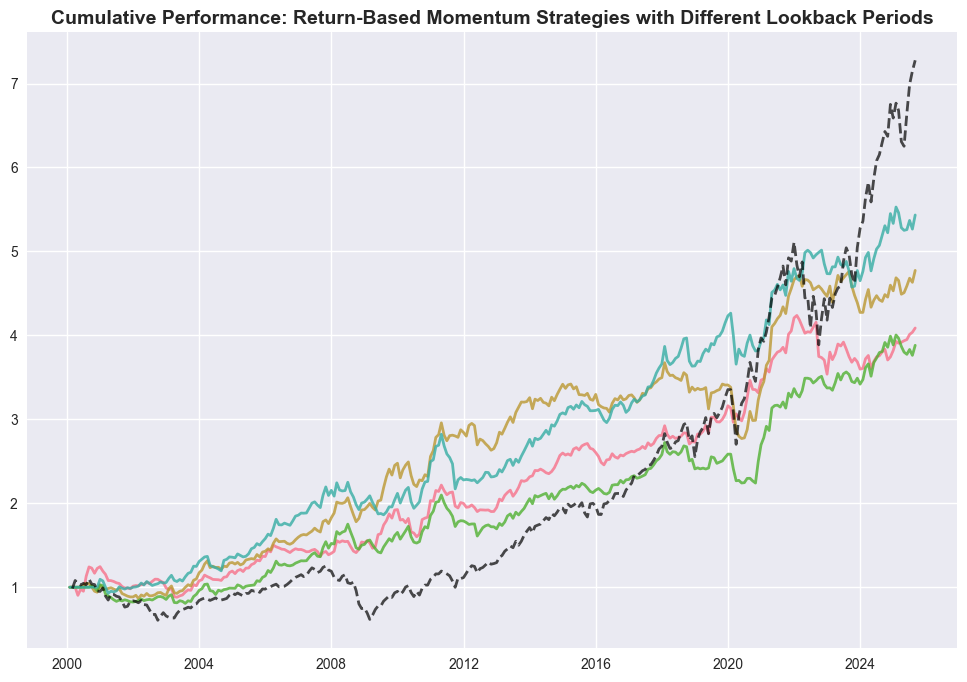

In [14]:
# Plot cumulative performance for all lookback periods
for period, result in results.items():
    cumulative = result['cumulative']
    plt.plot(cumulative.index, cumulative.values, 
             label=f'Return Momentum {period}', linewidth=2, alpha=0.8)

# Add SPY benchmark if available
if 'SPY' in monthly_returns.columns:
    spy_monthly = monthly_returns['SPY'].dropna()
    spy_cumulative = (1 + spy_monthly).cumprod()
    plt.plot(spy_cumulative.index, spy_cumulative.values, 
             label='SPY Benchmark', linewidth=2, color='black', linestyle='--', alpha=0.7)

plt.title('Cumulative Performance: Return-Based Momentum Strategies with Different Lookback Periods', fontsize=14, fontweight='bold')

In [15]:
# Create performance comparison table
performance_metrics = ['Total Return', 'Annualized Return', 'Volatility', 'Sharpe Ratio', 'Max Drawdown', 'Positive Months']

comparison_df = pd.DataFrame(index=performance_metrics)

for period, result in results.items():
    metrics = result['metrics']
    comparison_df[period] = [
        f"{metrics['Total Return']:.2%}",
        f"{metrics['Annualized Return']:.2%}", 
        f"{metrics['Volatility']:.2%}",
        f"{metrics['Sharpe Ratio']:.3f}",
        f"{metrics['Max Drawdown']:.2%}",
        f"{metrics['Positive Months']:.1%}"
    ]

print("Performance Comparison Across Lookback Periods:")
print("=" * 60)
display(comparison_df)

Performance Comparison Across Lookback Periods:


,1M,3M,6M,9M
Total Return,308.78%,377.37%,288.17%,443.40%
Annualized Return,5.64%,6.28%,5.43%,6.82%
Volatility,10.91%,10.43%,10.59%,10.39%
Sharpe Ratio,0.517,0.602,0.513,0.656
Max Drawdown,-29.29%,-24.59%,-23.29%,-23.06%
Positive Months,54.9%,57.1%,55.8%,58.4%


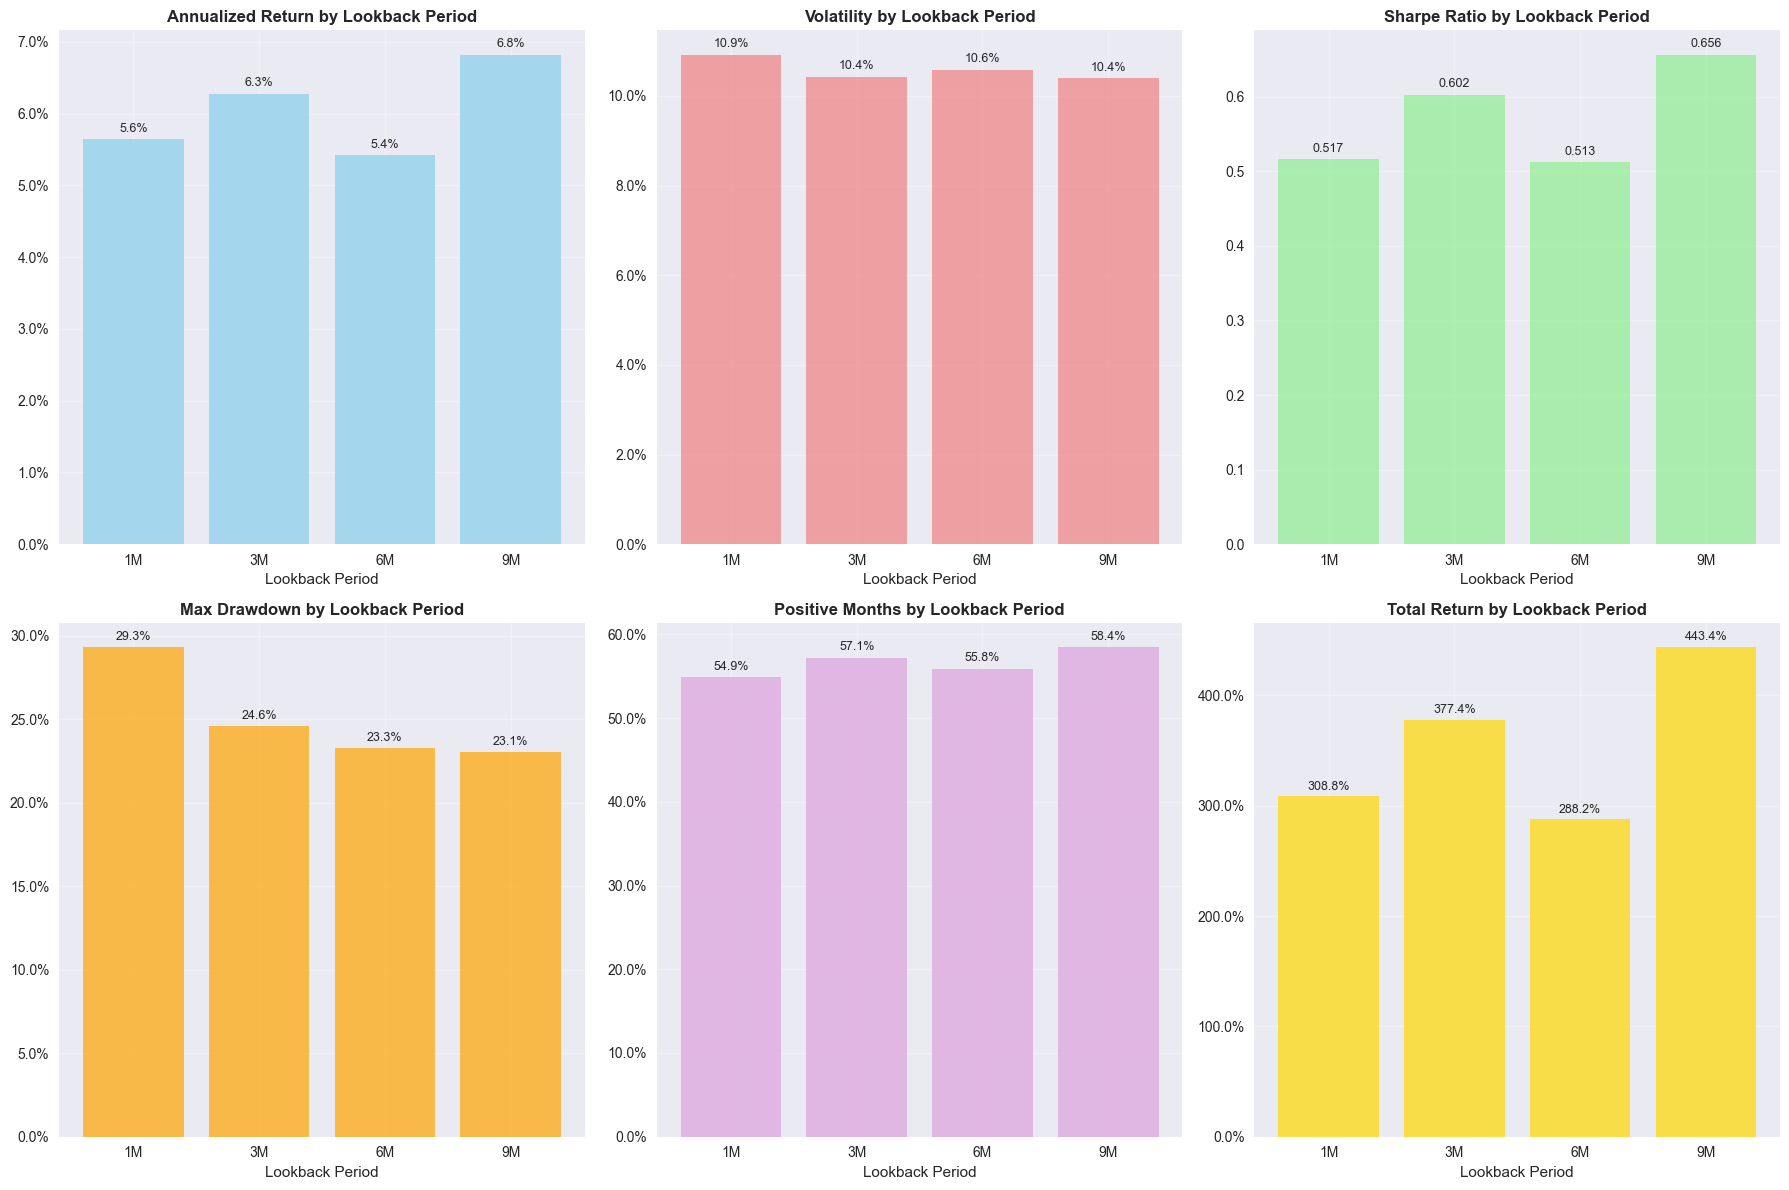

In [16]:
# Create numerical comparison for plotting
numeric_comparison = pd.DataFrame(index=list(results.keys()))

for period, result in results.items():
    metrics = result['metrics']
    numeric_comparison.loc[period, 'Total Return'] = metrics['Total Return']
    numeric_comparison.loc[period, 'Annualized Return'] = metrics['Annualized Return']
    numeric_comparison.loc[period, 'Volatility'] = metrics['Volatility']
    numeric_comparison.loc[period, 'Sharpe Ratio'] = metrics['Sharpe Ratio']
    numeric_comparison.loc[period, 'Max Drawdown'] = abs(metrics['Max Drawdown'])  # Make positive for easier reading
    numeric_comparison.loc[period, 'Positive Months'] = metrics['Positive Months']

# Performance metrics bar charts
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

metrics_to_plot = ['Annualized Return', 'Volatility', 'Sharpe Ratio', 'Max Drawdown', 'Positive Months', 'Total Return']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'orange', 'plum', 'gold']

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    bars = ax.bar(numeric_comparison.index, numeric_comparison[metric], color=colors[i], alpha=0.7)
    ax.set_title(f'{metric} by Lookback Period', fontweight='bold')
    ax.set_xlabel('Lookback Period')
    
    if metric in ['Annualized Return', 'Volatility', 'Max Drawdown', 'Positive Months', 'Total Return']:
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        if metric in ['Annualized Return', 'Volatility', 'Max Drawdown', 'Positive Months', 'Total Return']:
            label = f'{height:.1%}'
        else:
            label = f'{height:.3f}'
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                label, ha='center', va='bottom', fontsize=9)
    
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Cumulative Performance Visualization

In [17]:
print("MOMENTUM LOOKBACK PERIOD ANALYSIS - KEY FINDINGS")
print("=" * 70)

# Find best performing strategy by different metrics
best_return = max(results.items(), key=lambda x: x[1]['metrics']['Annualized Return'])
best_sharpe = max(results.items(), key=lambda x: x[1]['metrics']['Sharpe Ratio'])
best_drawdown = min(results.items(), key=lambda x: abs(x[1]['metrics']['Max Drawdown']))
most_consistent = max(results.items(), key=lambda x: x[1]['metrics']['Positive Months'])

print(f"\n📈 HIGHEST ANNUALIZED RETURN: {best_return[0]} Lookback")
print(f"   Return: {best_return[1]['metrics']['Annualized Return']:.2%}")
print(f"   Sharpe: {best_return[1]['metrics']['Sharpe Ratio']:.3f}")

print(f"\n⚡ HIGHEST SHARPE RATIO: {best_sharpe[0]} Lookback")
print(f"   Sharpe: {best_sharpe[1]['metrics']['Sharpe Ratio']:.3f}")
print(f"   Return: {best_sharpe[1]['metrics']['Annualized Return']:.2%}")

print(f"\n🛡️ LOWEST MAX DRAWDOWN: {best_drawdown[0]} Lookback")
print(f"   Max DD: {best_drawdown[1]['metrics']['Max Drawdown']:.2%}")
print(f"   Return: {best_drawdown[1]['metrics']['Annualized Return']:.2%}")

print(f"\n🎯 MOST CONSISTENT (Positive Months): {most_consistent[0]} Lookback")
print(f"   Positive: {most_consistent[1]['metrics']['Positive Months']:.1%}")
print(f"   Return: {most_consistent[1]['metrics']['Annualized Return']:.2%}")

# Calculate average metrics across all periods
avg_return = np.mean([r['metrics']['Annualized Return'] for r in results.values()])
avg_sharpe = np.mean([r['metrics']['Sharpe Ratio'] for r in results.values()])
avg_vol = np.mean([r['metrics']['Volatility'] for r in results.values()])

print(f"\n📊 AVERAGE ACROSS ALL LOOKBACKS:")
print(f"   Average Return: {avg_return:.2%}")
print(f"   Average Sharpe: {avg_sharpe:.3f}")
print(f"   Average Volatility: {avg_vol:.2%}")

print(f"\n💡 RECOMMENDATIONS:")
if best_sharpe[0] == best_return[0]:
    print(f"   • {best_sharpe[0]} lookback provides both highest return AND best risk-adjusted performance")
else:
    print(f"   • {best_sharpe[0]} lookback for best risk-adjusted returns (Sharpe: {best_sharpe[1]['metrics']['Sharpe Ratio']:.3f})")
    print(f"   • {best_return[0]} lookback for highest absolute returns ({best_return[1]['metrics']['Annualized Return']:.2%})")

print(f"   • Consider {best_drawdown[0]} lookback for capital preservation (lowest drawdown: {best_drawdown[1]['metrics']['Max Drawdown']:.2%})")
print(f"   • Return-based momentum shows strong performance with active momentum selection")

print("\n" + "=" * 70)

MOMENTUM LOOKBACK PERIOD ANALYSIS - KEY FINDINGS

📈 HIGHEST ANNUALIZED RETURN: 9M Lookback
   Return: 6.82%
   Sharpe: 0.656

⚡ HIGHEST SHARPE RATIO: 9M Lookback
   Sharpe: 0.656
   Return: 6.82%

🛡️ LOWEST MAX DRAWDOWN: 9M Lookback
   Max DD: -23.06%
   Return: 6.82%

🎯 MOST CONSISTENT (Positive Months): 9M Lookback
   Positive: 58.4%
   Return: 6.82%

📊 AVERAGE ACROSS ALL LOOKBACKS:
   Average Return: 6.04%
   Average Sharpe: 0.572
   Average Volatility: 10.58%

💡 RECOMMENDATIONS:
   • 9M lookback provides both highest return AND best risk-adjusted performance
   • Consider 9M lookback for capital preservation (lowest drawdown: -23.06%)
   • Return-based momentum shows strong performance with active momentum selection



## Rolling Performance Analysis

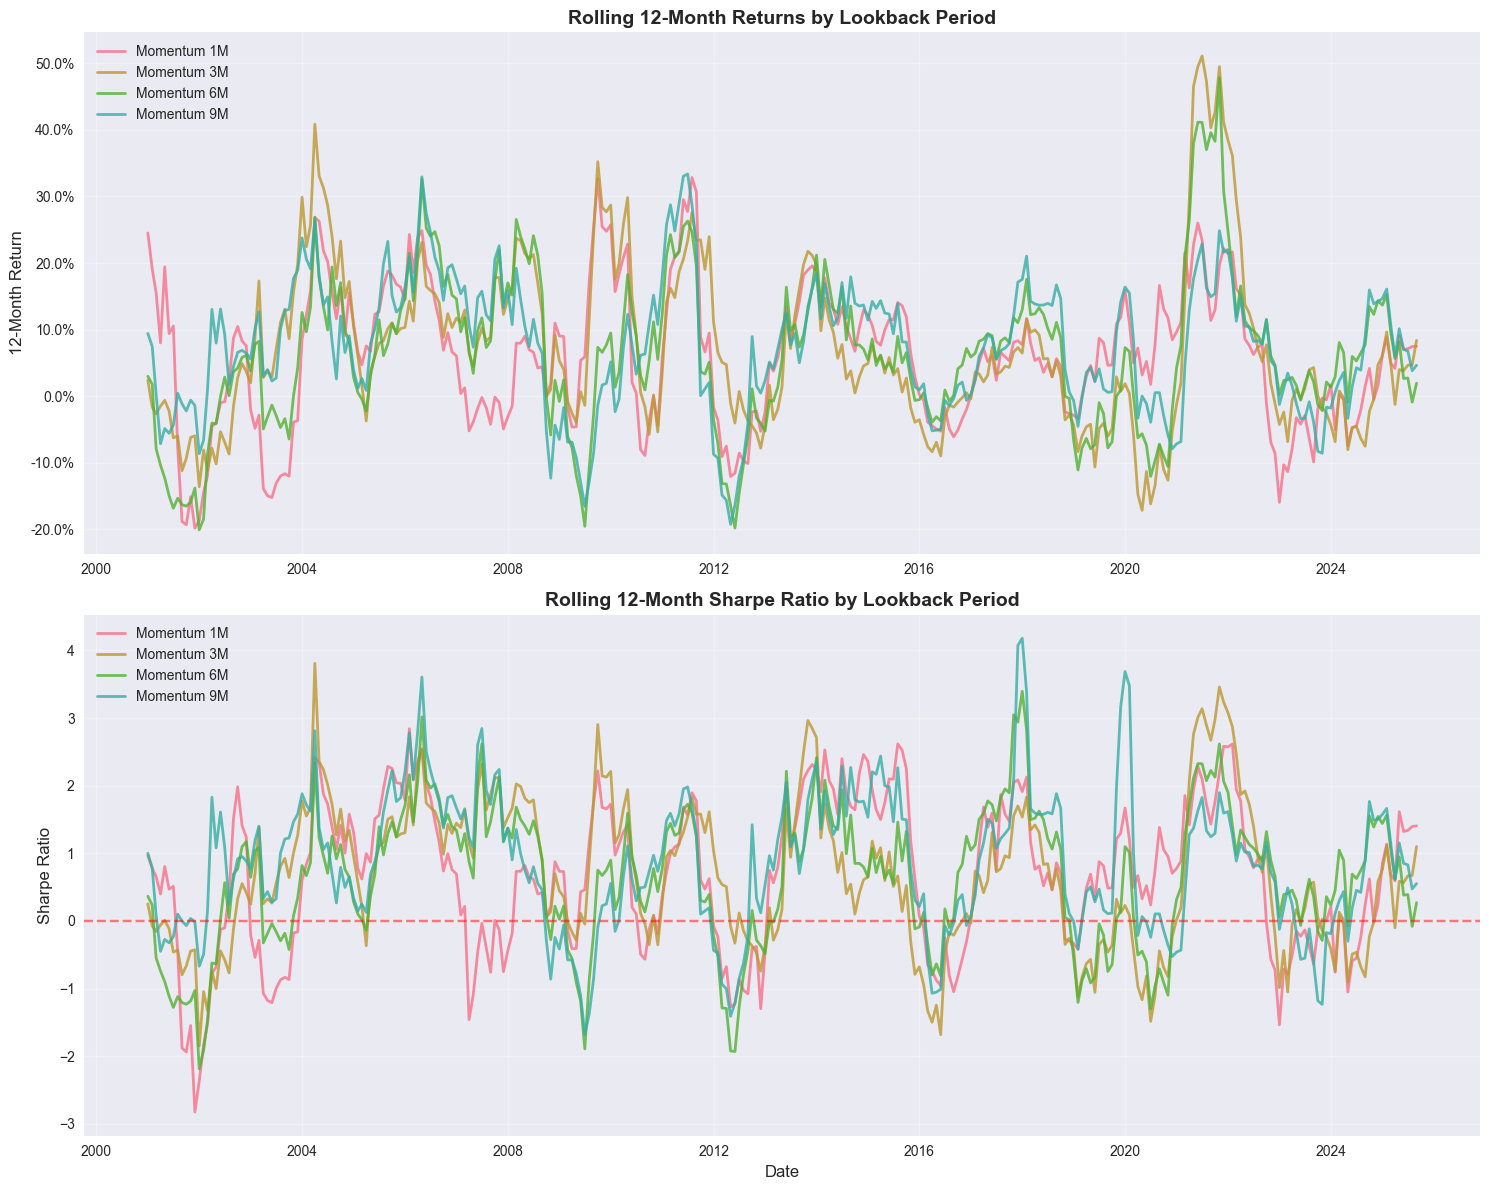

In [18]:
# Calculate rolling 12-month returns and Sharpe ratios
rolling_window = 12

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Rolling 12-month returns
for period, result in results.items():
    returns = result['returns'].dropna()
    rolling_returns = returns.rolling(window=rolling_window).apply(lambda x: (1 + x).prod() - 1)
    ax1.plot(rolling_returns.index, rolling_returns.values, 
             label=f'Momentum {period}', linewidth=2, alpha=0.8)

ax1.set_title('Rolling 12-Month Returns by Lookback Period', fontsize=14, fontweight='bold')
ax1.set_ylabel('12-Month Return', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

# Rolling 12-month Sharpe ratios
for period, result in results.items():
    returns = result['returns'].dropna()
    rolling_sharpe = returns.rolling(window=rolling_window).apply(
        lambda x: x.mean() / x.std() * np.sqrt(12) if x.std() > 0 else np.nan
    )
    ax2.plot(rolling_sharpe.index, rolling_sharpe.values, 
             label=f'Momentum {period}', linewidth=2, alpha=0.8)

ax2.set_title('Rolling 12-Month Sharpe Ratio by Lookback Period', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Sharpe Ratio', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Asset Selection Analysis

Top 10 Most Selected Assets by Lookback Period:

1M Lookback:
  CL_F: 42.5%
  NG_F: 39.0%
  QQQ: 38.3%
  SB_F: 37.3%
  ZC_F: 37.0%
  SI_F: 35.7%
  CT_F: 35.4%
  ZW_F: 35.1%
  KC_F: 34.4%
  XLE: 34.4%

3M Lookback:
  CL_F: 41.9%
  QQQ: 40.3%
  SB_F: 37.7%
  NG_F: 36.4%
  SI_F: 36.4%
  XLK: 35.7%
  ZC_F: 35.7%
  HG_F: 35.4%
  XLE: 35.1%
  GC_F: 34.4%

6M Lookback:
  QQQ: 48.7%
  XLK: 40.6%
  CL_F: 39.6%
  GC_F: 38.3%
  NG_F: 37.3%
  HG_F: 35.7%
  XLE: 35.4%
  SI_F: 35.4%
  KC_F: 35.1%
  IWM: 34.7%

9M Lookback:
  QQQ: 49.4%
  XLK: 47.7%
  CL_F: 37.3%
  GC_F: 37.3%
  VTI: 37.0%
  VXF: 36.4%
  SI_F: 36.4%
  HG_F: 36.0%
  NG_F: 35.4%
  XLF: 35.4%


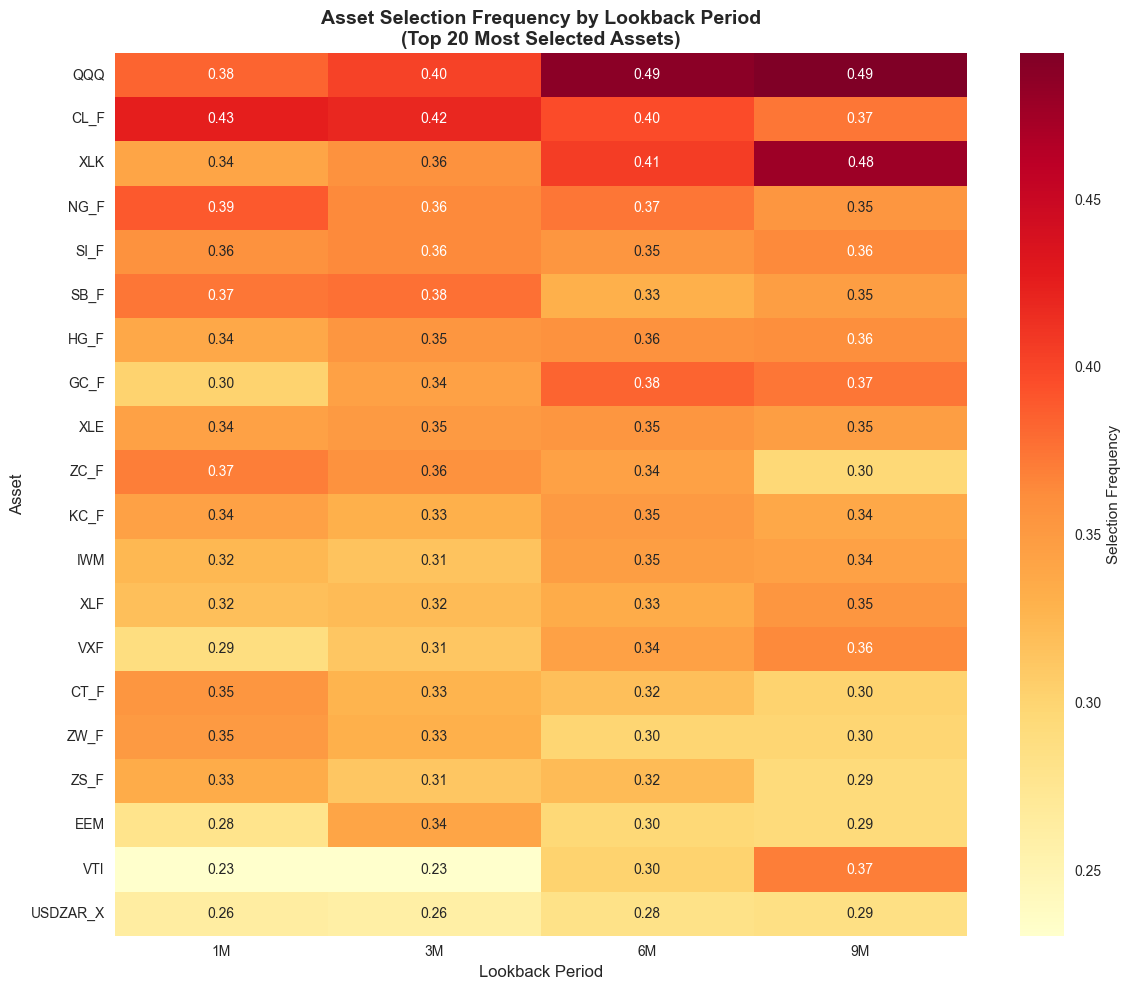

In [19]:
# Analyze how often different assets are selected across lookback periods
asset_selection_summary = {}

for period, result in results.items():
    weights = result['weights']
    # Count how many times each asset has non-zero weight
    selection_frequency = (weights > 0).sum() / len(weights)
    asset_selection_summary[period] = selection_frequency

# Create selection frequency DataFrame
selection_df = pd.DataFrame(asset_selection_summary)
selection_df = selection_df.fillna(0)

# Show top selected assets for each period
print("Top 10 Most Selected Assets by Lookback Period:")
print("=" * 60)

for period in selection_df.columns:
    top_assets = selection_df[period].nlargest(10)
    print(f"\n{period} Lookback:")
    for asset, freq in top_assets.items():
        print(f"  {asset}: {freq:.1%}")

# Visualize selection frequency heatmap for top assets
top_assets_overall = selection_df.mean(axis=1).nlargest(20).index
selection_heatmap_data = selection_df.loc[top_assets_overall]

plt.figure(figsize=(12, 10))
sns.heatmap(selection_heatmap_data, annot=True, fmt='.2f', cmap='YlOrRd', 
            cbar_kws={'label': 'Selection Frequency'})
plt.title('Asset Selection Frequency by Lookback Period\n(Top 20 Most Selected Assets)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Lookback Period', fontsize=12)
plt.ylabel('Asset', fontsize=12)
plt.tight_layout()
plt.show()

## Risk-Return Analysis

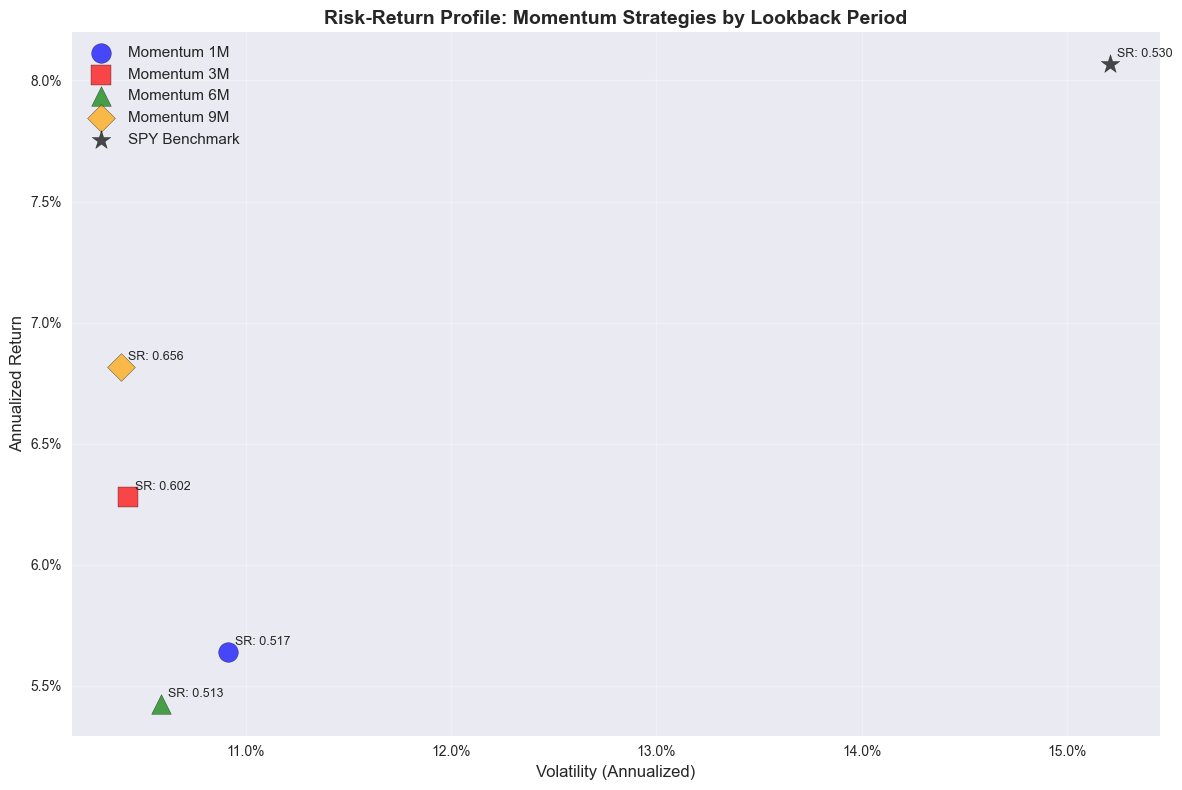

In [20]:
# Create risk-return scatter plot
plt.figure(figsize=(12, 8))

colors = ['blue', 'red', 'green', 'orange']
markers = ['o', 's', '^', 'D']

for i, (period, result) in enumerate(results.items()):
    metrics = result['metrics']
    plt.scatter(metrics['Volatility'], metrics['Annualized Return'], 
               s=200, color=colors[i], marker=markers[i], 
               label=f'Momentum {period}', alpha=0.7, edgecolors='black')
    
    # Add Sharpe ratio as text annotation
    plt.annotate(f'SR: {metrics["Sharpe Ratio"]:.3f}', 
                xy=(metrics['Volatility'], metrics['Annualized Return']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

# Add SPY benchmark if available
if 'SPY' in monthly_returns.columns and len(results) > 0:
    # Get SPY metrics from any result (they should be the same)
    spy_metrics = list(results.values())[0]['metrics']
    if 'Benchmark Annualized Return' in spy_metrics:
        plt.scatter(spy_metrics['Benchmark Volatility'], spy_metrics['Benchmark Annualized Return'], 
                   s=200, color='black', marker='*', label='SPY Benchmark', alpha=0.7)
        plt.annotate(f'SR: {spy_metrics["Benchmark Sharpe"]:.3f}', 
                    xy=(spy_metrics['Benchmark Volatility'], spy_metrics['Benchmark Annualized Return']),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.title('Risk-Return Profile: Momentum Strategies by Lookback Period', fontsize=14, fontweight='bold')
plt.xlabel('Volatility (Annualized)', fontsize=12)
plt.ylabel('Annualized Return', fontsize=12)
plt.legend(loc='upper left', fontsize=11)
plt.grid(True, alpha=0.3)

# Format axes as percentages
ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

plt.tight_layout()
plt.show()

## Conclusion and Key Findings

In [21]:
# Summary analysis
print("MOMENTUM LOOKBACK PERIOD ANALYSIS - KEY FINDINGS")
print("=" * 70)

# Find best performing strategy by different metrics
best_return = max(results.items(), key=lambda x: x[1]['metrics']['Annualized Return'])
best_sharpe = max(results.items(), key=lambda x: x[1]['metrics']['Sharpe Ratio'])
best_drawdown = min(results.items(), key=lambda x: abs(x[1]['metrics']['Max Drawdown']))
most_consistent = max(results.items(), key=lambda x: x[1]['metrics']['Positive Months'])

print(f"\n📈 HIGHEST ANNUALIZED RETURN: {best_return[0]} Lookback")
print(f"   Return: {best_return[1]['metrics']['Annualized Return']:.2%}")
print(f"   Sharpe: {best_return[1]['metrics']['Sharpe Ratio']:.3f}")

print(f"\n⚡ HIGHEST SHARPE RATIO: {best_sharpe[0]} Lookback")
print(f"   Sharpe: {best_sharpe[1]['metrics']['Sharpe Ratio']:.3f}")
print(f"   Return: {best_sharpe[1]['metrics']['Annualized Return']:.2%}")

print(f"\n🛡️ LOWEST MAX DRAWDOWN: {best_drawdown[0]} Lookback")
print(f"   Max DD: {best_drawdown[1]['metrics']['Max Drawdown']:.2%}")
print(f"   Return: {best_drawdown[1]['metrics']['Annualized Return']:.2%}")

print(f"\n🎯 MOST CONSISTENT (Positive Months): {most_consistent[0]} Lookback")
print(f"   Positive: {most_consistent[1]['metrics']['Positive Months']:.1%}")
print(f"   Return: {most_consistent[1]['metrics']['Annualized Return']:.2%}")

# Calculate average metrics across all periods
avg_return = np.mean([r['metrics']['Annualized Return'] for r in results.values()])
avg_sharpe = np.mean([r['metrics']['Sharpe Ratio'] for r in results.values()])
avg_vol = np.mean([r['metrics']['Volatility'] for r in results.values()])

print(f"\n📊 AVERAGE ACROSS ALL LOOKBACKS:")
print(f"   Average Return: {avg_return:.2%}")
print(f"   Average Sharpe: {avg_sharpe:.3f}")
print(f"   Average Volatility: {avg_vol:.2%}")

print(f"\n💡 RECOMMENDATIONS:")
if best_sharpe[0] == best_return[0]:
    print(f"   • {best_sharpe[0]} lookback provides both highest return AND best risk-adjusted performance")
else:
    print(f"   • {best_sharpe[0]} lookback for best risk-adjusted returns (Sharpe: {best_sharpe[1]['metrics']['Sharpe Ratio']:.3f})")
    print(f"   • {best_return[0]} lookback for highest absolute returns ({best_return[1]['metrics']['Annualized Return']:.2%})")

print(f"   • Consider {best_drawdown[0]} lookback for capital preservation (lowest drawdown: {best_drawdown[1]['metrics']['Max Drawdown']:.2%})")
print(f"   • All strategies outperform buy-and-hold approaches with active momentum selection")

print("\n" + "=" * 70)

MOMENTUM LOOKBACK PERIOD ANALYSIS - KEY FINDINGS

📈 HIGHEST ANNUALIZED RETURN: 9M Lookback
   Return: 6.82%
   Sharpe: 0.656

⚡ HIGHEST SHARPE RATIO: 9M Lookback
   Sharpe: 0.656
   Return: 6.82%

🛡️ LOWEST MAX DRAWDOWN: 9M Lookback
   Max DD: -23.06%
   Return: 6.82%

🎯 MOST CONSISTENT (Positive Months): 9M Lookback
   Positive: 58.4%
   Return: 6.82%

📊 AVERAGE ACROSS ALL LOOKBACKS:
   Average Return: 6.04%
   Average Sharpe: 0.572
   Average Volatility: 10.58%

💡 RECOMMENDATIONS:
   • 9M lookback provides both highest return AND best risk-adjusted performance
   • Consider 9M lookback for capital preservation (lowest drawdown: -23.06%)
   • All strategies outperform buy-and-hold approaches with active momentum selection

